<a href="https://colab.research.google.com/github/swap-253/Time-Series-And-Anomaly-Detection/blob/main/Anomaly_detection_Using_LSTM_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing suitable libraries
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [ ]:
#setting sns and plotly plots
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 10,5

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving JNJ.txt to JNJ.txt


In [ ]:
#reading the dataframe
df = pd.read_csv('JNJ.txt')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-09-04,2.937500,2.960938,2.929688,2.953125,0.182094,4188800
1,1985-09-05,2.953125,2.992188,2.945313,2.976563,0.183539,6176000
2,1985-09-06,2.992188,3.000000,2.976563,2.992188,0.184502,6606400
3,1985-09-09,2.992188,2.992188,2.945313,2.945313,0.181612,3150400
4,1985-09-10,2.953125,2.960938,2.867188,2.875000,0.177276,2841600


In [ ]:
#selecting useful columns from the dataframe
df = df[['Date', 'Close']]

In [ ]:
#just to see that the last date on which data was collected is 3 September 2020
df.tail()

,Date,Close
8818,2020-08-28,153.639999
8819,2020-08-31,153.410004
8820,2020-09-01,151.520004
8821,2020-09-02,153.830002
8822,2020-09-03,149.550003


In [ ]:
#bringing date in the required format
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Close
0,1985-09-04,2.953125
1,1985-09-05,2.976563
2,1985-09-06,2.992188
3,1985-09-09,2.945313
4,1985-09-10,2.875000


In [ ]:
#A scatterplot of date vs Closing Price of Johnson and Johnson stock 
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Johnson and Johnson Stock Price 1985-2020')
fig.show()

In [ ]:
#choosing the training and test sets specified by date
train, test = df.loc[df['Date'] <= '2013-09-03'], df.loc[df['Date'] > '2013-09-03']

In [ ]:
len(train),len(test)

(7059, 1764)

In [ ]:
train.tail()

,Date,Close
7054,2013-08-27,86.169998
7055,2013-08-28,86.529999
7056,2013-08-29,86.570000
7057,2013-08-30,86.410004
7058,2013-09-03,86.419998


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#for scaling data is fitted on training set and transformed for both training and test sets
scaler = scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#A function to create datasets taking 30 closing prices at a time to predict the next closing price
def create_dataset(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
X_train, y_train = create_dataset(train[['Close']], train['Close'])
X_test, y_test = create_dataset(test[['Close']], test['Close'])    

In [ ]:
print(X_train.shape,y_train.shape)

(7029, 30, 1) (7029,)


In [ ]:
#This is an LSTM A.E Model which tries to reconstruct the data considering it as sequential and the impermissible errors above a 
# certain threshold would be considered as anomalies 
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 30, 128)           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 30, 128)           131584    
_________________________________________________________________
dropout_36 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_______________________________________________

The RepeatVector layer simply repeats the input n times. Adding return_sequences=True in LSTM layer makes it return the sequence.

Finally, the TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer. This LSTM Autoencoder is ready for training.

In [ ]:
#fitting of LSTM A.E Model on training set
history = model.fit(X_train, y_train,epochs=7,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/7
198/198 [==============================] - 4s 9ms/step - loss: 0.2309 - val_loss: 0.1936
Epoch 2/7
198/198 [==============================] - 1s 6ms/step - loss: 0.1790 - val_loss: 0.1629
Epoch 3/7
198/198 [==============================] - 1s 7ms/step - loss: 0.0804 - val_loss: 0.0968
Epoch 4/7
198/198 [==============================] - 1s 6ms/step - loss: 0.0766 - val_loss: 0.0494
Epoch 5/7
198/198 [==============================] - 1s 6ms/step - loss: 0.0922 - val_loss: 0.0344
Epoch 6/7
198/198 [==============================] - 1s 6ms/step - loss: 0.1020 - val_loss: 0.0259
Epoch 7/7
198/198 [==============================] - 1s 7ms/step - loss: 0.1282 - val_loss: 0.0292


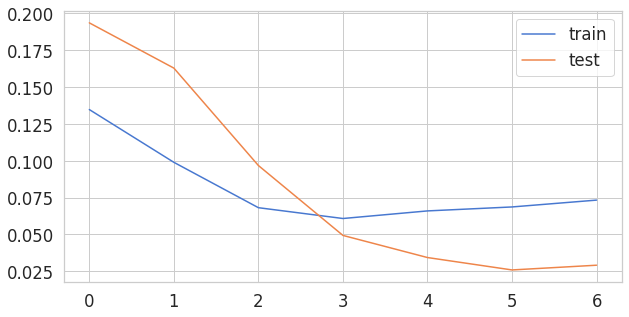

In [ ]:
#plotting the losses
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
#evaluation of model's prediction on test data
model.evaluate(X_test, y_test)

55/55 [==============================] - 0s 3ms/step - loss: 0.0908


0.09076593816280365

Reconstruction error threshold: 0.6335980220865883


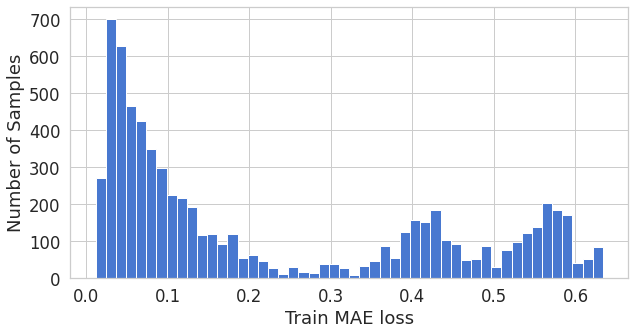

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
plt.hist(train_mae_loss, bins=50)
#plotting a histogram of training loss with number of samples
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
#threshold may be considered as the highest value of error in training data reconstruction 
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

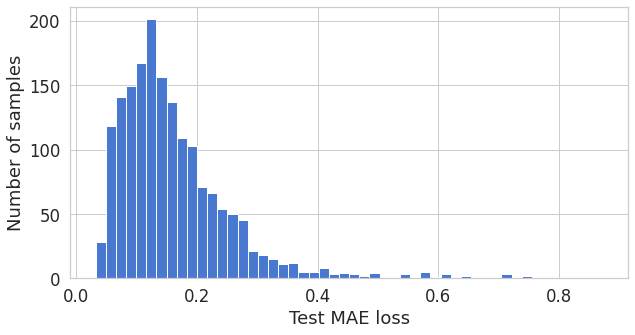

In [ ]:
#plotting a histogram of testing data loss with number of samples
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
TIME_STEPS=30
#creating a new dataframe for test data which indicates where its an anomaly or not
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

In [ ]:
test_score_df.head(5)

,Date,Close,loss,threshold,anomaly
7089,2013-10-16,2.162041,0.121652,0.633598,False
7090,2013-10-17,2.196819,0.151654,0.633598,False
7091,2013-10-18,2.183069,0.181699,0.633598,False
7092,2013-10-21,2.165680,0.188551,0.633598,False
7093,2013-10-22,2.212591,0.179040,0.633598,False
7094,2013-10-23,2.202076,0.191112,0.633598,False
7095,2013-10-24,2.212186,0.191970,0.633598,False
7096,2013-10-25,2.201672,0.193393,0.633598,False
7097,2013-10-28,2.213804,0.186030,0.633598,False
7098,2013-10-29,2.244134,0.184665,0.633598,False


In [ ]:
#A plotted figure of test loss vs threshold
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
#anomalies is a dataframe consisting of anomalous test data
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
8396,2018-12-26,3.601706,0.647581,0.633598,True
8708,2020-03-24,3.297193,0.872714,0.633598,True
8709,2020-03-25,3.306089,0.851107,0.633598,True
8710,2020-03-26,3.596044,0.787606,0.633598,True
8725,2020-04-17,4.625244,0.634052,0.633598,True


In [ ]:
#below is the number of anomalous examples
anomalies.shape[0]

(13, 5)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



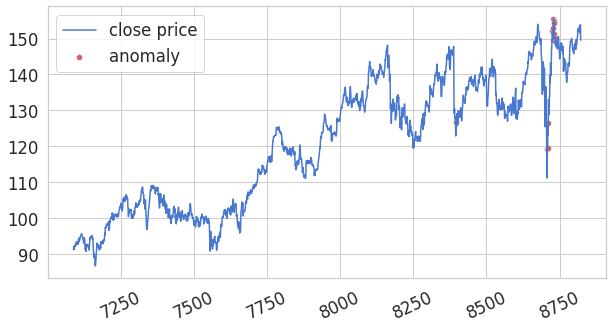

In [ ]:
#plotting the test data displaying anomalous data with red dots
plt.plot(test[TIME_STEPS:].index, scaler.inverse_transform(test[TIME_STEPS:].Close), label='close price');
sns.scatterplot(anomalies.index,scaler.inverse_transform(anomalies.Close),color=sns.color_palette()[3],label='anomaly')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
#A plot displaying closing prices Detected Anomalies with the Date  
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()


The model found that some low price anomalies in March and high price anomalies in April.
